<a href="https://colab.research.google.com/github/siddu49/Minor_Project/blob/main/Final_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [280]:
!pip install spectral vit-pytorch

In [281]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from vit_pytorch import ViT

In [282]:
# Loading Indian Pines Dataset
data = loadmat('indian_pines_corrected.mat')['indian_pines_corrected']
gt = loadmat('indian_pines_gt.mat')['indian_pines_gt']

print(f"Data shape: {data.shape}")
print(f"Ground truth shape: {gt.shape}")

Data shape: (145, 145, 200)
Ground truth shape: (145, 145)


In [283]:
# Data Normalization
data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))


In [284]:
# PCA Reduction to 3 Components
D = 3
reshaped = data_norm.reshape(-1, data_norm.shape[-1])
pca = PCA(n_components=D)
reshaped_pca = pca.fit_transform(reshaped)
data_pca = reshaped_pca.reshape(data_norm.shape[0], data_norm.shape[1], D)
print(f"PCA data shape: {data_pca.shape}")

PCA data shape: (145, 145, 3)


In [285]:
# Patch Extraction
def extract_patches(img, gt, size=75, stride=5):
    patches = []
    labels = []
    for i in range(0, img.shape[0] - size + 1, stride):
        for j in range(0, img.shape[1] - size + 1, stride):
            patch = img[i:i+size, j:j+size, :]
            center_label = gt[i + size//2, j + size//2]
            if center_label != 0:
                patches.append(patch)
                labels.append(center_label - 1)
    return np.array(patches), np.array(labels)

patches, labels = extract_patches(data_pca, gt, size=75, stride=5)
print(f"Extracted {len(patches)} patches")

Extracted 126 patches


In [286]:
# Data Augmentation
def augment_data(patches, labels):
    augmented_patches = []
    augmented_labels = []

    for patch, label in zip(patches, labels):
        augmented_patches.append(patch)
        augmented_labels.append(label)

        patch_flip = np.flip(patch, axis=1).copy()
        augmented_patches.append(patch_flip)
        augmented_labels.append(label)

        patch_flip_v = np.flip(patch, axis=0).copy()
        augmented_patches.append(patch_flip_v)
        augmented_labels.append(label)

    return np.array(augmented_patches), np.array(augmented_labels)

patches_aug, labels_aug = augment_data(patches, labels)
print(f"After augmentation: {patches_aug.shape}")

After augmentation: (378, 75, 75, 3)


In [287]:
# Dataset Preparation
X_tensor = torch.FloatTensor(patches_aug).permute(0, 3, 1, 2)
y_tensor = torch.LongTensor(labels_aug)
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.3, random_state=42, stratify=y_tensor
)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 264, Testing: 114


In [288]:
# Vision Transformer Model
model = ViT(
    image_size=75,
    patch_size=5,
    num_classes=16,
    channels=3,
    dim=64,
    depth=3,
    heads=4,
    mlp_dim=128,
    dropout=0.1,
    emb_dropout=0.1
)

In [289]:
# Training Setup
device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [290]:
# Training
train_losses = []
train_accuracies = []
epochs = 60
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

Epoch [1/60], Loss: 2.2072, Accuracy: 23.86%
Epoch [2/60], Loss: 1.4323, Accuracy: 43.94%
Epoch [3/60], Loss: 1.2825, Accuracy: 50.38%
Epoch [4/60], Loss: 1.1704, Accuracy: 57.58%
Epoch [5/60], Loss: 0.9880, Accuracy: 59.47%
Epoch [6/60], Loss: 0.9728, Accuracy: 65.15%
Epoch [7/60], Loss: 0.8863, Accuracy: 61.74%
Epoch [8/60], Loss: 0.8229, Accuracy: 62.50%
Epoch [9/60], Loss: 0.7714, Accuracy: 67.80%
Epoch [10/60], Loss: 0.7273, Accuracy: 70.08%
Epoch [11/60], Loss: 0.6429, Accuracy: 75.00%
Epoch [12/60], Loss: 0.6788, Accuracy: 72.73%
Epoch [13/60], Loss: 0.6803, Accuracy: 73.86%
Epoch [14/60], Loss: 0.6380, Accuracy: 71.97%
Epoch [15/60], Loss: 0.5762, Accuracy: 76.52%
Epoch [16/60], Loss: 0.5619, Accuracy: 76.89%
Epoch [17/60], Loss: 0.5433, Accuracy: 78.79%
Epoch [18/60], Loss: 0.4896, Accuracy: 81.06%
Epoch [19/60], Loss: 0.4659, Accuracy: 81.82%
Epoch [20/60], Loss: 0.3702, Accuracy: 87.88%
Epoch [21/60], Loss: 0.3714, Accuracy: 85.61%
Epoch [22/60], Loss: 0.3385, Accuracy: 86.7

In [291]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)

        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
accuracy = 100. * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 85.96%


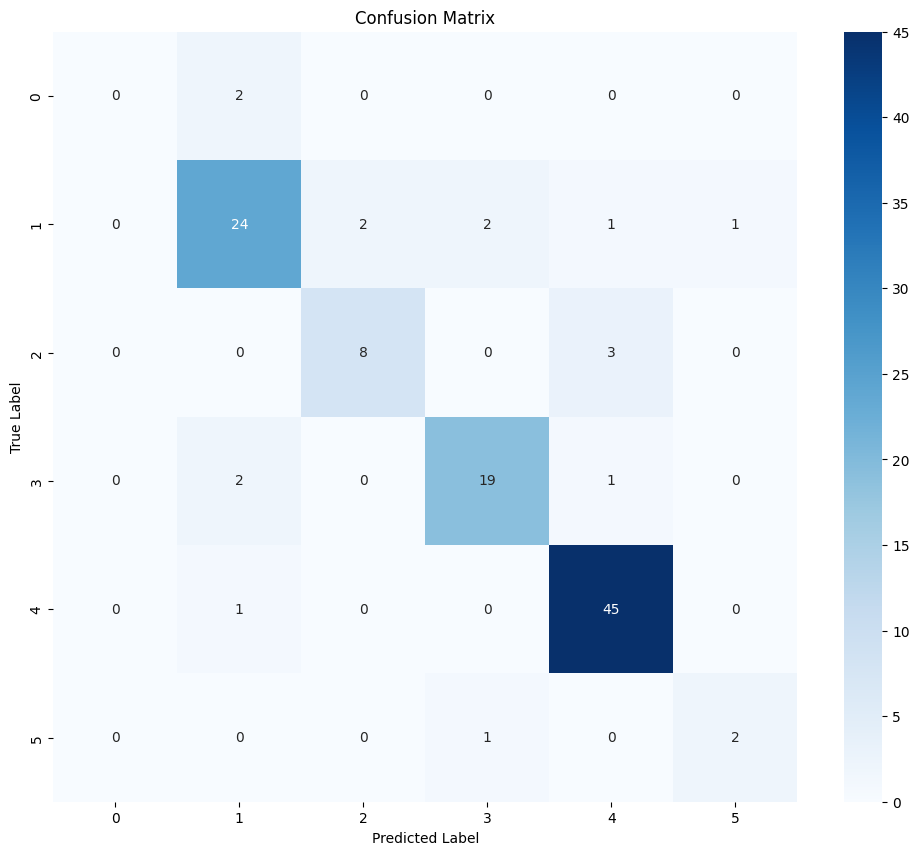


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.83      0.80      0.81        30
           5       0.80      0.73      0.76        11
           9       0.86      0.86      0.86        22
          10       0.90      0.98      0.94        46
          13       0.67      0.67      0.67         3

    accuracy                           0.86       114
   macro avg       0.68      0.67      0.67       114
weighted avg       0.84      0.86      0.85       114

Cohen's Kappa: 0.8022


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [292]:
# Evaluation Metrics
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa: {kappa:.4f}")


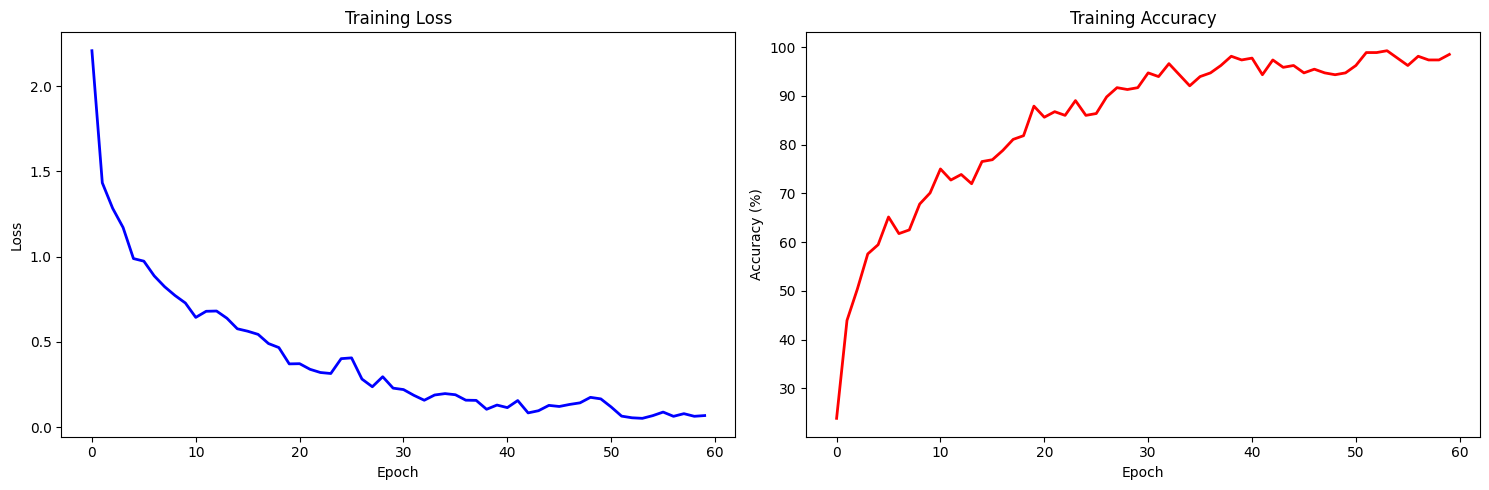

In [293]:

# Training Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r-', linewidth=2)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()


In [294]:

# Save Model
torch.save(model.state_dict(), 'pca_vit_model.pth')
print("Model saved successfully!")

Model saved successfully!


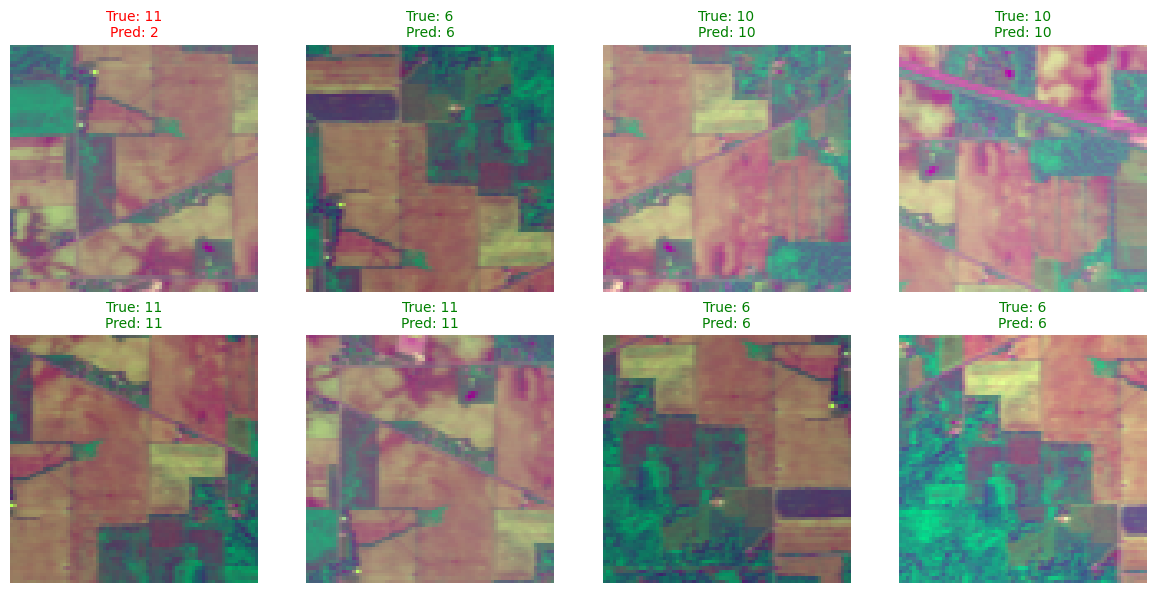

In [295]:
# Predictions vs Ground Truth
sample_indices = np.random.choice(len(X_test), 8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, sample_idx in enumerate(sample_indices):
    sample_data = X_test[sample_idx].unsqueeze(0).to(device)
    true_label = y_test[sample_idx].item()

    with torch.no_grad():
        pred = model(sample_data).argmax(dim=1).item()

    patch_rgb = sample_data[0].cpu().permute(1, 2, 0).numpy()
    patch_rgb = (patch_rgb - patch_rgb.min()) / (patch_rgb.max() - patch_rgb.min())

    axes[idx//4, idx%4].imshow(patch_rgb)
    color = 'green' if true_label == pred else 'red'
    axes[idx//4, idx%4].set_title(f'True: {true_label+1}\nPred: {pred+1}', color=color, fontsize=10)
    axes[idx//4, idx%4].axis('off')

plt.tight_layout()
plt.show()